## Bike Share Regression Analysis

### Brief context
The dataset contains information about the weather, holidays, weekends and if a customer is casual or registered.

#### Features:
- instant: record index
- dteday : date
- season : season (1:spring, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2018, 1:2019)
- mnth : month ( 1 to 12)
- holiday : weather day is a holiday or not
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit : 
	- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
	- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
	- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
	- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : temperature in Celsius
- atemp: feeling temperature in Celsius
- hum: humidity
- windspeed: wind speed
- casual: count of casual users
- registered: count of registered users

#### Label:
- cnt: count of total rental bikes including both casual and registered
       
Dataset source: https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset

# 1. Loading libraries and dataset

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler , StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

import xgboost as xgb

random_state = 5

import warnings
warnings.filterwarnings('ignore')
# xgb.set_config(verbosity=0) # Disabling XGBoost warnings. Comment this line if your XGBoost model doesn't work and you need investigation.

In [49]:
# Reading the dataset
df = pd.read_csv("_usc-csc300-202201-Task1-Bikeshare.csv")

In [50]:
# Let's take a look at the first few rows
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [51]:
# Let's look at the number of rows and columns in the dataset
df.shape

(730, 16)

In [52]:
# Understanding the feature names in the dataset
df.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

In [53]:
# Getting insights of the features
df.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


In [54]:
# Summary of the dataset: 730 rows, 16 columns, no null values
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB
None


# 2. EDA

In [55]:
year_counts = df['yr'].value_counts()

print(year_counts)

#Reveals that there is an equal distribution of entries for 2018 and 2019.

0    365
1    365
Name: yr, dtype: int64


<Axes: >

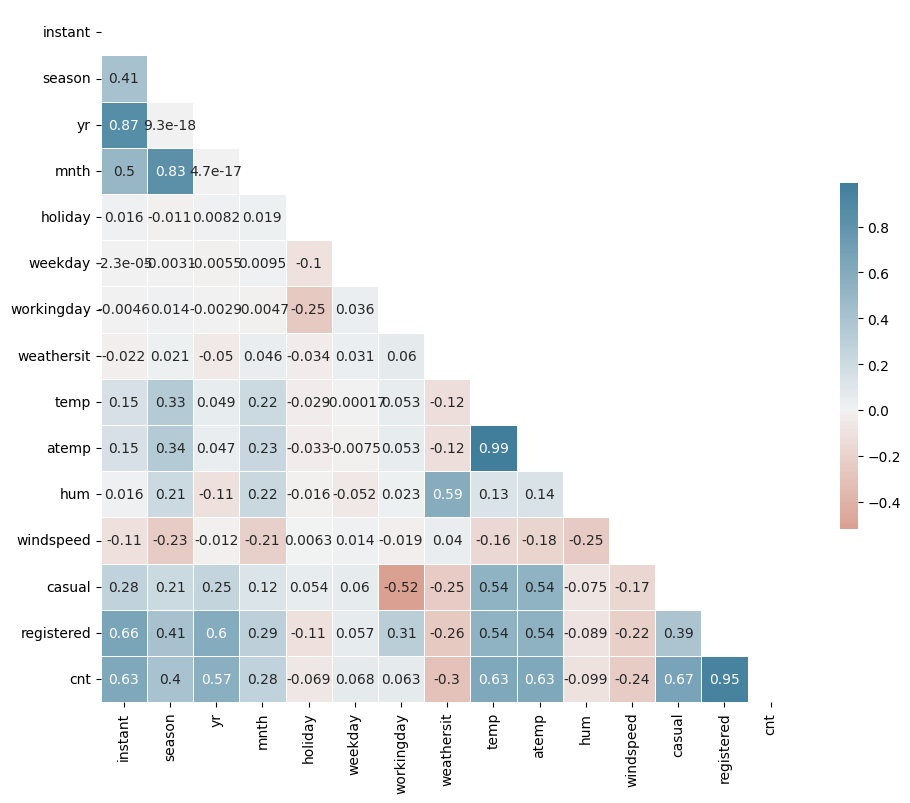

In [56]:
# Create a correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))

cmap = sns.diverging_palette(20, 230, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, 
            cbar_kws={"shrink": .5},
            annot=True)

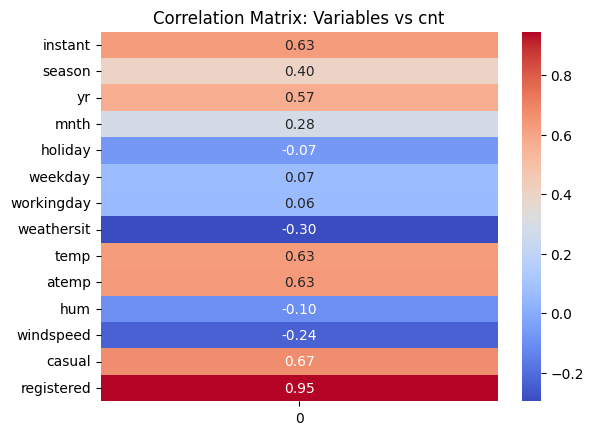

In [57]:
# Calculate the correlation matrix
corr_matrix = df.drop('cnt', axis=1).corrwith(df['cnt'])

# Plot the correlation matrix
sns.heatmap(corr_matrix.to_frame(), cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Correlation Matrix: Variables vs cnt')
plt.show()

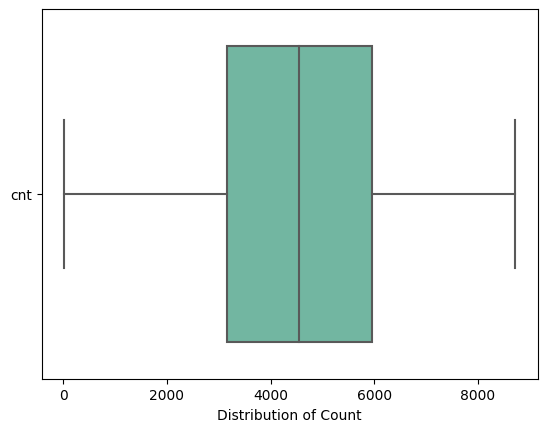

In [58]:
#Plot the distribution of cnt using a box plot
ax = sns.boxplot(data=df[["cnt"]], orient="h", palette="Set2")
ax.set_xlabel("Distribution of Count")
plt.show()

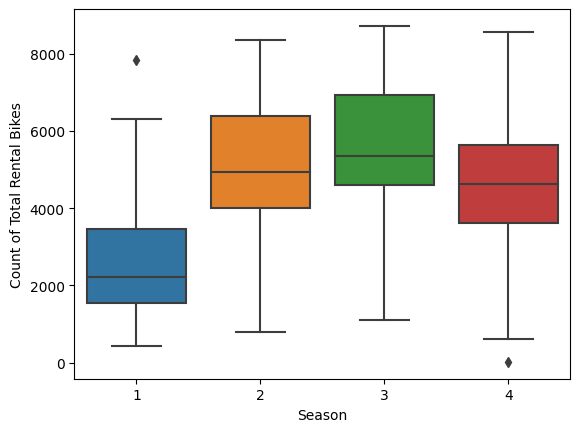

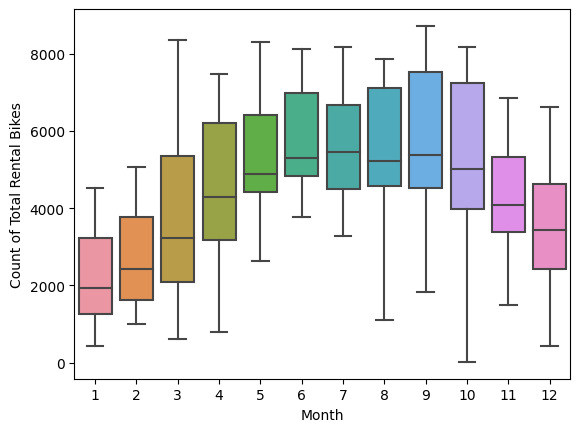

In [59]:
# Create a box plot for season
sns.boxplot(x='season', y='cnt', data=df)
plt.xlabel('Season')
plt.ylabel('Count of Total Rental Bikes')
plt.show()

# Create a box plot for mnth
sns.boxplot(x='mnth', y='cnt', data=df)
plt.xlabel('Month')
plt.ylabel('Count of Total Rental Bikes')
plt.show()

#This shows the same pattern as season, but season has a stronger correlation. Therefore this feature might be redundant.

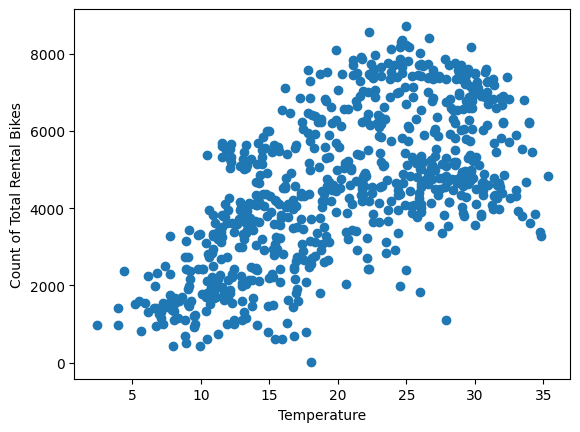

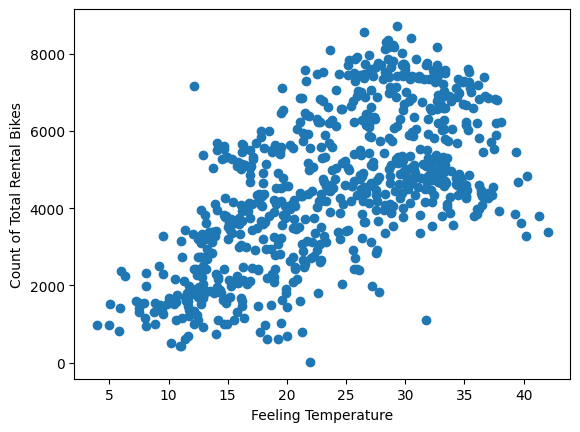

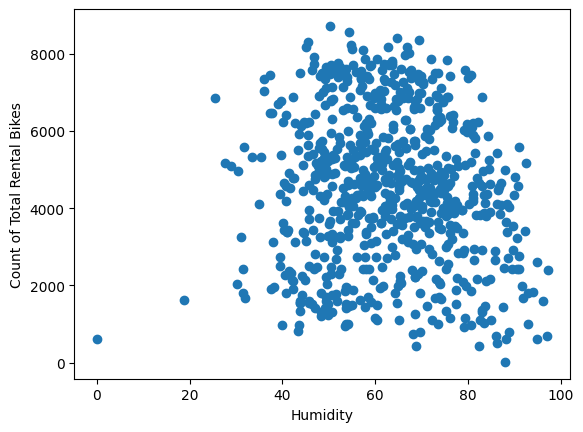

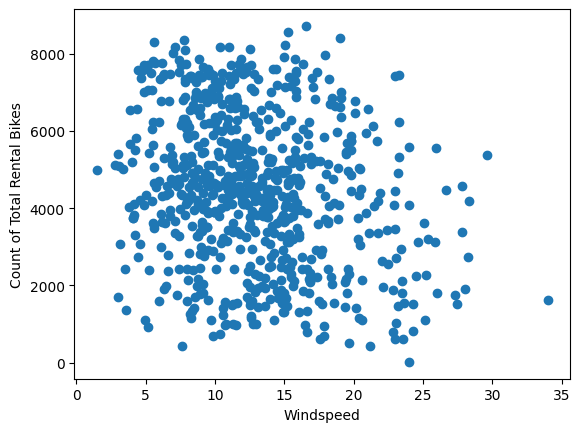

In [60]:
# Create a scatter plot for temp
plt.scatter(df['temp'], df['cnt'])
plt.xlabel('Temperature')
plt.ylabel('Count of Total Rental Bikes')
plt.show()

# Create a scatter plot for atemp
plt.scatter(df['atemp'], df['cnt'])
plt.xlabel('Feeling Temperature')
plt.ylabel('Count of Total Rental Bikes')
plt.show()

# Create a scatter plot for hum
plt.scatter(df['hum'], df['cnt'])
plt.xlabel('Humidity')
plt.ylabel('Count of Total Rental Bikes')
plt.show()

# Create a scatter plot for windspeed
plt.scatter(df['windspeed'], df['cnt'])
plt.xlabel('Windspeed')
plt.ylabel('Count of Total Rental Bikes')
plt.show()

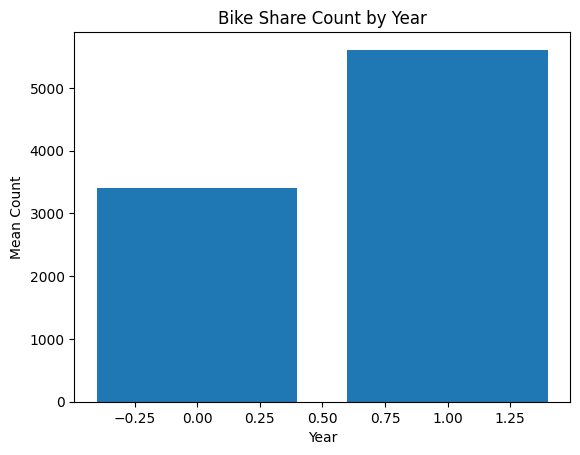

In [61]:
# Group the data by year and calculate the mean count
year_cnt = df.groupby('yr')['cnt'].mean()

# Create a bar plot
plt.bar(x=year_cnt.index, height=year_cnt.values)
plt.xlabel('Year')
plt.ylabel('Mean Count')
plt.title('Bike Share Count by Year')
plt.show()

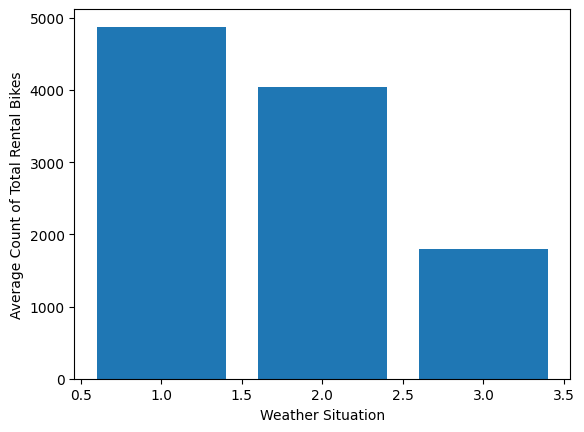

In [62]:
# Group the data by weathersit and calculate the mean count
weather_count = df.groupby('weathersit')['cnt'].mean()

# Create a bar plot
plt.bar(weather_count.index, weather_count.values)
plt.xlabel('Weather Situation')
plt.ylabel('Average Count of Total Rental Bikes')
plt.show()

#There are NO entries for weather situation 4 (heavy rain, thunderstorm etc!!) which implies that this is a good indicator for no sales.

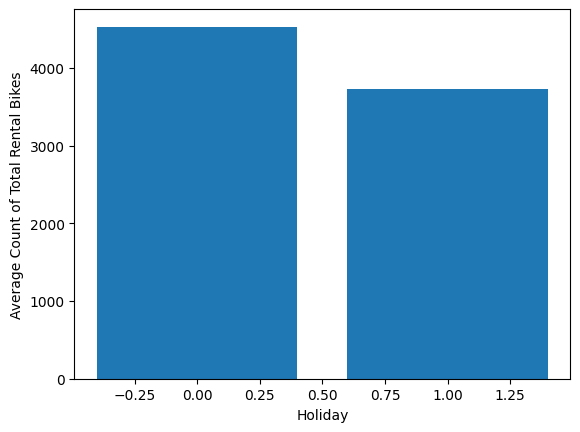

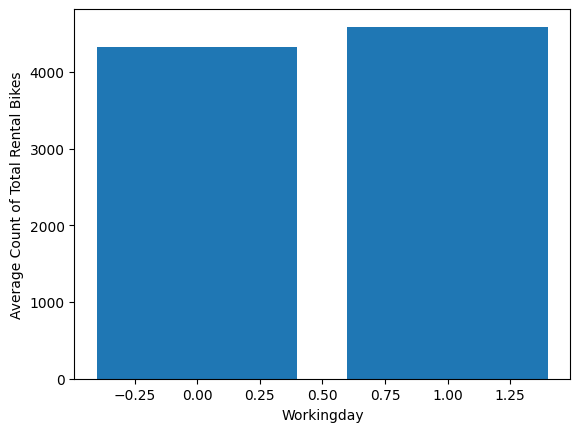

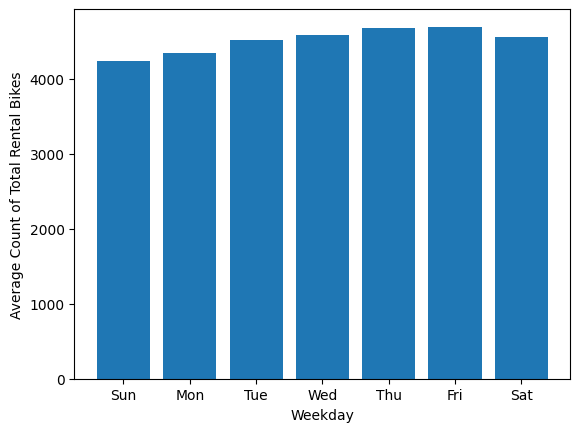

In [63]:
# Create a bar plot for holiday
holiday_count = df.groupby('holiday')['cnt'].mean()
plt.bar(holiday_count.index, holiday_count.values)
plt.xlabel('Holiday')
plt.ylabel('Average Count of Total Rental Bikes')
plt.show()

# Create a bar plot for workingday
workingday_count = df.groupby('workingday')['cnt'].mean()
plt.bar(workingday_count.index, workingday_count.values)
plt.xlabel('Workingday')
plt.ylabel('Average Count of Total Rental Bikes')
plt.show()

# Create a bar plot for weekday
weekday_count = df.groupby('weekday')['cnt'].mean()
plt.bar(weekday_count.index, weekday_count.values)
plt.xlabel('Weekday')
plt.ylabel('Average Count of Total Rental Bikes')
plt.xticks(weekday_count.index, ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
plt.show()

#Holiday, workday, and weekday all show a very slight correlation to cnt so may not strongly affect the model and may cause overcomplexity.

# 3. Data Preparation 


# Outlier Treatment

In [64]:
# Drop dteday
df.drop('dteday', axis=1, inplace=True)

# Define a function to detect outliers based on IQR
def detect_outliers_iqr(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = {}
    for col in df.columns:
        outliers[col] = df[(df[col] < lower_bound[col]) | (df[col] > upper_bound[col])].index.tolist()
    return outliers

# Apply the function to df
outliers = detect_outliers_iqr(df)

# Print the indices of the outliers for each column
for col in df.columns:
    print(col, outliers[col])
    
# Drop the outliers from the "humidity" and "windspeed" columns
#df = df.drop(outliers["hum"] + outliers["windspeed"])

#Model performs worse after removing outliers! So outliers are kept.

instant []
season []
yr []
mnth []
holiday [16, 51, 104, 149, 184, 247, 282, 314, 327, 359, 366, 380, 415, 470, 512, 549, 610, 645, 680, 690, 723]
weekday []
workingday []
weathersit []
temp []
atemp []
hum [49, 68]
windspeed [44, 49, 93, 94, 292, 382, 407, 420, 431, 432, 449, 665, 720]
casual [148, 183, 184, 196, 246, 281, 440, 446, 454, 455, 461, 468, 469, 475, 489, 496, 503, 504, 510, 511, 512, 517, 518, 524, 531, 532, 538, 539, 549, 559, 567, 580, 594, 608, 609, 616, 622, 629, 630, 636, 643, 657, 664, 679]
registered []
cnt []


# Dummifying

In [65]:
# Dummify the 'season' column
dummies = pd.get_dummies(df['season'], prefix='season')
# Concatenate the dummies with the original DataFrame
df = pd.concat([df, dummies], axis=1)
df.drop('season', axis=1, inplace=True)

# Repeat for weathersit
dummies = pd.get_dummies(df['weathersit'], prefix='weathersit')
df = pd.concat([df, dummies], axis=1)
df.drop('weathersit', axis=1, inplace=True)

# Repeat for mnth
dummies = pd.get_dummies(df['mnth'], prefix='mnth')
df = pd.concat([df, dummies], axis=1)
df.drop('mnth', axis=1, inplace=True)

In [66]:
df.describe()

,instant,yr,holiday,weekday,workingday,temp,atemp,hum,windspeed,casual,...,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,...,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,0.500000,0.028767,2.997260,0.683562,20.319259,23.726322,62.765175,12.763620,849.249315,...,0.084932,0.082192,0.084932,0.082192,0.084932,0.084932,0.082192,0.084932,0.082192,0.084932
std,210.877136,0.500343,0.167266,2.006161,0.465405,7.506729,8.150308,14.237589,5.195841,686.479875,...,0.278971,0.274845,0.278971,0.274845,0.278971,0.278971,0.274845,0.278971,0.274845,0.278971
min,1.000000,0.000000,0.000000,0.000000,0.000000,2.424346,3.953480,0.000000,1.500244,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,183.250000,0.000000,0.000000,1.000000,0.000000,13.811885,16.889713,52.000000,9.041650,316.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,365.500000,0.500000,0.000000,3.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,547.750000,1.000000,0.000000,5.000000,1.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,730.000000,1.000000,1.000000,6.000000,1.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# 4. Model Building and Evaluation


# Dropping Irrelevant Features

In [67]:
X = df.drop(['cnt', 'registered', 'instant', 'casual'], axis = 1)
y = df["cnt"]
X.head()

,yr,holiday,weekday,workingday,temp,atemp,hum,windspeed,season_1,season_2,...,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12
0,0,0,6,0,14.110847,18.18125,80.5833,10.749882,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,14.902598,17.68695,69.6087,16.652113,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,1,8.050924,9.47025,43.7273,16.636703,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,2,1,8.200000,10.60610,59.0435,10.739832,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,3,1,9.305237,11.46350,43.6957,12.522300,1,0,...,0,0,0,0,0,0,0,0,0,0


In [68]:
y.head()

0     985
1     801
2    1349
3    1562
4    1600
Name: cnt, dtype: int64

In [69]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 27 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   yr            730 non-null    int64  
 1   holiday       730 non-null    int64  
 2   weekday       730 non-null    int64  
 3   workingday    730 non-null    int64  
 4   temp          730 non-null    float64
 5   atemp         730 non-null    float64
 6   hum           730 non-null    float64
 7   windspeed     730 non-null    float64
 8   season_1      730 non-null    uint8  
 9   season_2      730 non-null    uint8  
 10  season_3      730 non-null    uint8  
 11  season_4      730 non-null    uint8  
 12  weathersit_1  730 non-null    uint8  
 13  weathersit_2  730 non-null    uint8  
 14  weathersit_3  730 non-null    uint8  
 15  mnth_1        730 non-null    uint8  
 16  mnth_2        730 non-null    uint8  
 17  mnth_3        730 non-null    uint8  
 18  mnth_4        730 non-null    

# Creating training and test dataset

In [70]:
# Set the test size to 20%
test_size = 0.2

# Create the feature and label train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size  = test_size,
                                                    random_state = random_state)

# Scaling

In [71]:
##
##
# Models perform worse after scaling! So scaling is left out.
##
##

# scaler = StandardScaler()

# X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X.columns)
# X_test = pd.DataFrame(scaler.transform(X_test), columns = X.columns)

# Modeling

# Simple Linear Regression

In [72]:
# Create a simple regressor
lr = LinearRegression()

# Fit the model to the training sets
lr.fit(X_train,y_train)

X_train.columns

# Use the model to make predictions on the test set
y_hat = lr.predict(X_test)

# Print the RMSE 
rmse = mean_squared_error(y_test, y_hat, squared=False)
print("Linear Regression RMSE:", rmse)

# Print the r2 score
r2 = r2_score(y_test, y_hat)
print("Linear Regression r2:", r2)

Linear Regression RMSE: 745.1050035497578
Linear Regression r2: 0.8574631364433922


# Ridge Regression

In [73]:
# Create a ridge regressor
ridge = Ridge(random_state = random_state, max_iter = 10000)

# Set parameters
alphas = np.logspace(-4,-0.5,30)
tuned_parameters = [{'alpha':alphas}]
n_folds = 5

# Create a grid search to identify the best parameters
clf = GridSearchCV(ridge,
                   tuned_parameters,
                   cv = n_folds,
                   scoring= "neg_mean_squared_error",
                   refit = True)

# Perform the search on the training sets
clf.fit(X_train, y_train)

print("Ridge Best Estimator:", clf.best_estimator_, '\n')

# Make predictions on the test set
y_hat = clf.predict(X_test)

# Print the results
rmse = mean_squared_error(y_test, y_hat, squared=False)
print("Ridge RMSE:", rmse)
r2 = r2_score(y_test, y_hat)
print("Ridge r2:", r2)

Ridge Best Estimator: Ridge(alpha=0.31622776601683794, max_iter=10000, random_state=5) 

Ridge RMSE: 746.2382269002161
Ridge r2: 0.8570292407291098


# Lasso Regression

In [74]:
# Define the hyperparameters grid
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100],
              'max_iter': [1000, 5000, 10000]}

# Create a Lasso regressor
lasso = Lasso()

# Perform a grid search to find the best model
grid_search = GridSearchCV(lasso, param_grid=param_grid, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

# Print the results
best_rmse = -grid_search.best_score_
best_r2 = r2_score(y_test, grid_search.predict(X_test))
print("Best RMSE:", best_rmse)
print("Best R2 Score:", best_r2)

Best RMSE: 788.3107612207552
Best R2 Score: 0.8544166158616903


# Run several algorithms and compare results

In [75]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Create the regression models to be tested
models = {'Linear Regression': LinearRegression(),
          'Lasso Regression': Lasso(),
          'Ridge Regression': Ridge(),
          'Elastic Net Regression': ElasticNet(),
          'Decision Tree Regression': DecisionTreeRegressor(),
          'Random Forest Regression': RandomForestRegressor(),
          'Support Vector Regression': SVR(),
          'Gaussian Process Regression': GaussianProcessRegressor(),
          'K-Nearest Neighbors Regression': KNeighborsRegressor(),
          'Polynomial Regression': make_pipeline(PolynomialFeatures(degree=2), LinearRegression()),
          'Multi-layer Perceptron Regression': MLPRegressor()}

# Create lists to store the model results
model_names = []
rmse_values = []
r2_values = []

# Loop through each model and fit the data
for name, model in models.items():
    model_names.append(name)
    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_hat))
    rmse_values.append(rmse)
    r2 = r2_score(y_test, y_hat)
    r2_values.append(r2)
    
# Create a dataframe to store the results
df_results = pd.DataFrame({'Model': model_names,
                           'RMSE': rmse_values,
                           'R2': r2_values})

# Sort the results by RMSE in ascending order
df_results.sort_values(by='RMSE', ascending=True, inplace=True)

# Print results
print(df_results)

                                Model          RMSE            R2
5            Random Forest Regression  6.544007e+02  8.900539e-01
0                   Linear Regression  7.451050e+02  8.574631e-01
2                    Ridge Regression  7.486471e+02  8.561047e-01
1                    Lasso Regression  7.530257e+02  8.544166e-01
4            Decision Tree Regression  7.995504e+02  8.358715e-01
3              Elastic Net Regression  1.149010e+03  6.610464e-01
8      K-Nearest Neighbors Regression  1.275936e+03  5.820254e-01
10  Multi-layer Perceptron Regression  1.944563e+03  2.918555e-02
6           Support Vector Regression  1.971150e+03  2.457119e-03
7         Gaussian Process Regression  4.696671e+03 -4.663338e+00
9               Polynomial Regression  2.265107e+11 -1.317255e+16


# Decision Tree Regressor

In [76]:
np.random.seed(5)

# Define the parameter grid to search over
param_grid = {'max_depth': [3, 5, 7, None],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'max_leaf_nodes': [None, 5, 10, 20]}

# Create the regressor
tree_reg = DecisionTreeRegressor()

# Create the GridSearchCV object with cross-validation
grid_search = GridSearchCV(tree_reg, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X, y)

# Print the best hyperparameters and corresponding score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", -grid_search.best_score_)

# Use the best estimator to make predictions on the test set
best_tree_reg = grid_search.best_estimator_
y_pred = best_tree_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("RMSE: ", rmse)
print("R2: ", r2)

# Evaluate the model's performance on the training set
train_score = best_tree_reg.score(X_train, y_train)
print(f"\nTraining score: {train_score}")

# Evaluate the model's performance on the test set
test_score = best_tree_reg.score(X_test, y_test)
print(f"Test score: {test_score}")

# Compare the training and validation scores
if train_score > test_score:
    print("Model is overfitting")
else:
    print("Model is not overfitting")
    
# Print the depth and number of leaf nodes of the decision tree
depth = best_tree_reg.tree_.max_depth
num_leaves = best_tree_reg.tree_.n_leaves
print("\nDepth:", depth)
print("Number of leaves:", num_leaves)    

Best hyperparameters:  {'max_depth': None, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best score:  1399591.4968512177
RMSE:  220.81084866579442
R2:  0.9874820546153024

Training score: 0.9856102260335805
Test score: 0.9874820546153024
Model is not overfitting

Depth: 23
Number of leaves: 291


# Random Forest

In [77]:
# Create the regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the Random Forest Regressor on the training set
rf.fit(X_train, y_train)

# Make predictions on the testing set
y_hat = rf.predict(X_test)

# Print the results
rmse = mean_squared_error(y_test, y_hat, squared=False)
print('RMSE:', rmse)
r2 = rf.score(X_test, y_test)
print('R-squared:', r2)

# Calculate the importances of each feature
print('\nFeature Importances:')
importances = rf.feature_importances_
categorical_features = {"yr", "holiday", "weekday", "workingday", "temp", "atemp","hum","windspeed","season","weathersit","mnth"}
    
# Create a dictionary to store the feature importances for each original categorical feature
feat_importances = {}
for feature in categorical_features:
    feat_importances[feature] = 0

# Aggregate the feature importances across the dummy variables that correspond to each original categorical feature
for i, col in enumerate(X.columns):
    feature = col.split('_')[0] # get the original categorical feature name
    if feature in categorical_features:
        feat_importances[feature] += importances[i]

# Print the feature importances for each original categorical feature
for feature, importance in sorted(feat_importances.items(), key=lambda x: x[1], reverse=True):
    print(feature, importance)

RMSE: 639.8692438966976
R-squared: 0.894882575864579

Feature Importances:
temp 0.3158137837661779
yr 0.2951932310372744
atemp 0.14260372639828478
season 0.08179994635640048
hum 0.06898120939338195
windspeed 0.03550647890712298
mnth 0.022899991516907567
weathersit 0.01779649375924483
weekday 0.014762356367086674
workingday 0.0036594579780253535
holiday 0.0009833245200929397


# XGBoost

In [78]:
# Define the parameters grid to search
parametersGrid  = {'nthread': [4],
                  'objective': ['reg:linear'],
                  'learning_rate':[0.03, 0.05, 0.07, 0.1],
                  'max_depth': [5, 6, 7],
                  'min_child_weight': [4],
                  'silent': [1],
                  'subsample': [0.7],
                  'colsample_bytree': [0.7],
                  'n_estimators':[500, 700, 1000]}

# Create the regressor
model_xgb = xgb.XGBRegressor()

# Create the grid search object
clf = GridSearchCV(model_xgb,
                   parametersGrid,
                   cv = n_folds,
                   scoring= "neg_mean_squared_error",
                   refit = True)

# Fit the grid search to the training data
clf.fit(X_train, y_train)
model_xgb = clf.best_estimator_

# Make predictions from the best model
y_hat = model_xgb.predict(X_test)
rmse = mean_squared_error(y_test,y_hat, squared=False)
print("XGBRegressor RMSE:", rmse)
r2 = r2_score(y_test, y_hat)
print("XGBRegressor r2:", r2)

# Re-engineering data to remove month and atemp

In [79]:
df = pd.read_csv("_usc-csc300-202201-Task1-Bikeshare.csv")

df = df.drop(["dteday", "atemp", "mnth", "registered", "instant", "casual"], axis=1)

# Dummify the 'season' column
dummies = pd.get_dummies(df['season'], prefix='season')
# Concatenate the dummies with the original DataFrame
df = pd.concat([df, dummies], axis=1)
df.drop('season', axis=1, inplace=True)

# Dummify weathersit
dummies = pd.get_dummies(df['weathersit'], prefix='weathersit')
df = pd.concat([df, dummies], axis=1)
df.drop('weathersit', axis=1, inplace=True)

# Split data into training and testing sets
X = df.drop(['cnt'], axis = 1)
y = df["cnt"]
X.head()

test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size  = test_size,
                                                    random_state = random_state)

# Remodelled Random Forest

In [80]:
##
##
## A grid search was performed on the regressor to find the best parameters. It took a long time to
## execute so the grid search has been commented out and the best parameters have been input manually.
##
##

# Define the hyperparameters to be tuned
# param_grid = {
#     'n_estimators': [50, 100, 200, 400],
#     'max_depth': [5, 10, 15, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
# }

# Create an instance of the random forest regressor
rf = RandomForestRegressor(random_state=42, max_depth=15, min_samples_leaf=1, min_samples_split=2,n_estimators=400)

# Create a GridSearchCV object and fit it to the training data
# grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
# grid_search.fit(X_train, y_train)

# Print the best hyperparameters
# print("Best hyperparameters: ", grid_search.best_params_)

# Fit the random forest regressor on the training data using the optimal hyperparameters
# rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# Make predictions on the testing set
y_hat = rf.predict(X_test)

# Print the results
rmse = mean_squared_error(y_test, y_hat, squared=False)
print('RMSE:', rmse)
r2 = rf.score(X_test, y_test)
print('R-squared:', r2)

# Calculate the feature importances
print('\nFeature Importances:')
importances = rf.feature_importances_
categorical_features = {"yr", "holiday", "weekday", "workingday", "temp","hum","windspeed","season","weathersit"}
    
# Create a dictionary to store the feature importances for each original categorical feature
feat_importances = {}
for feature in categorical_features:
    feat_importances[feature] = 0

# Aggregate the feature importances across the dummy variables that correspond to each original categorical feature
for i, col in enumerate(X.columns):
    feature = col.split('_')[0] # get the original categorical feature name
    if feature in categorical_features:
        feat_importances[feature] += importances[i]

# Print the feature importances for each original categorical feature
for feature, importance in sorted(feat_importances.items(), key=lambda x: x[1], reverse=True):
    print(feature, importance)

RMSE: 641.0445910357394
R-squared: 0.8944960502231698

Feature Importances:
temp 0.4582297205329036
yr 0.29344921285712217
season 0.08612320124390854
hum 0.07511444224133351
windspeed 0.04313740757340545
weathersit 0.021004536255663522
weekday 0.017182107615007332
workingday 0.004322359679063587
holiday 0.0014370120015922716


# Remodelled XGBoost

In [38]:
# Perform the XGBoost regression again on the reengineered dataset

parametersGrid  = {'nthread': [4],
                  'objective': ['reg:linear'],
                  'learning_rate':[0.03, 0.05, 0.07, 0.1],
                  'max_depth': [5, 6, 7],
                  'min_child_weight': [4],
                  'silent': [1],
                  'subsample': [0.7],
                  'colsample_bytree': [0.7],
                  'n_estimators':[500, 700, 1000]}

model_xgb = xgb.XGBRegressor()
clf = GridSearchCV(model_xgb,
                   parametersGrid,
                   cv = n_folds,
                   scoring= "neg_mean_squared_error",
                   refit = True)

clf.fit(X_train, y_train)
model_xgb = clf.best_estimator_
y_hat = clf.predict(X_test)
rmse = mean_squared_error(y_test,y_hat, squared=False)
print("XGBRegressor RMSE:", rmse)
r2 = r2_score(y_test, y_hat)
print("XGBRegressor r2:", r2)

[08:48:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[08:48:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language binding

[08:48:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[08:48:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language binding

[08:48:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[08:48:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language binding

[08:48:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[08:48:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language binding

[08:48:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[08:48:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language binding

[08:48:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[08:48:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language binding

[08:48:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[08:48:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language binding

[08:49:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[08:49:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[08:49:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[08:49:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language binding

[08:49:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[08:49:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[08:49:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[08:49:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language binding

[08:49:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[08:49:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[08:49:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[08:49:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language binding

[08:49:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[08:49:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[08:49:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[08:49:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language binding

[08:49:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[08:49:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[08:49:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[08:49:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language binding

[08:49:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[08:49:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[08:49:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[08:49:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language binding